In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [94]:
# path = 'logs/7juni_stage0/benchmark/model-998/FullTown01-v1_seed0/'
def read_data(path):
    df_sum = pd.read_csv(path + "/summary.csv")
    total_distance = 0
    
    for diag in glob.glob(path+'/diagnostics/*.csv'):
        total_distance += pd.read_csv(diag)['distance_to_goal'][0]
    
    return df_sum, total_distance

# df, dist = read_data(path)

In [235]:
def read(path):    
    all_towns = {"T1": {"Towns": ['NoCrashTown01-v1', 'NoCrashTown01-v3', 'NoCrashTown01-v5'], 'Data': []}, 
             "T1star": {"Towns": ['NoCrashTown01-v2', 'NoCrashTown01-v4', 'NoCrashTown01-v6'], 'Data': []}, 
             "T2": {"Towns": ['NoCrashTown02-v1', 'NoCrashTown02-v3', 'NoCrashTown02-v5'], 'Data': []}, 
             "T2star": {"Towns": ['NoCrashTown02-v2', 'NoCrashTown02-v4', 'NoCrashTown02-v6'], 'Data': []}}
    
#     all_towns = {"No traffic": {"Towns": ['NoCrashTown01-v1', 'NoCrashTown01-v2', 'NoCrashTown02-v1', 'NoCrashTown02-v2'], 'Data': []}, 
#              "Regular": {"Towns": ['NoCrashTown01-v3', 'NoCrashTown01-v4', 'NoCrashTown02-v3', 'NoCrashTown02-v4'], 'Data': []}, 
#              "Dense":     {"Towns": ['NoCrashTown01-v5', 'NoCrashTown01-v6', 'NoCrashTown02-v5', 'NoCrashTown02-v6'], 'Data': []},} 
    
#     all_towns = {"No traffic": {"Towns": ['NoCrashTown01-v1', 'NoCrashTown01-v2', 'NoCrashTown02-v1', 'NoCrashTown02-v2'], 'Data': []}, 
#              "Regular train": {"Towns": ['NoCrashTown01-v3', 'NoCrashTown01-v4',], 'Data': []}, 
#              "Dense train": {"Towns": ['NoCrashTown01-v5', 'NoCrashTown01-v6'], 'Data': []},
#             "Regular test": {"Towns": ['NoCrashTown02-v3', 'NoCrashTown02-v4'], 'Data': []}, 
#              "Dense test": {"Towns": ['NoCrashTown02-v5', 'NoCrashTown02-v6'], 'Data': []},                
#                 } 
    
#     all_towns = {"No traffic": {"Towns": ['FullTown01-v1', 'FullTown01-v2', 'FullTown02-v1', 'FullTown02-v2',
#                                           'StraightTown01-v1', 'StraightTown01-v2', 'StraightTown02-v1', 'StraightTown02-v2',
#                                          'TurnTown01-v1', 'TurnTown01-v2', 'TurnTown02-v1', 'TurnTown02-v2'], 'Data': []}, 
#              "Traffic": {"Towns": ['FullTown01-v3', 'FullTown01-v3', 'FullTown02-v3', 'FullTown02-v4'], 'Data': []}, 
#                 } 
    
    for t, towns in all_towns.items():
        df = None
        dist = 0
        for town in towns['Towns']:
            for i in range(3):
                df_temp, dist_temp = read_data(path + town + f"_seed{i}")
                dist += dist_temp
                if df is None:
                    df = df_temp
                else:
                    df = pd.concat([df, df_temp])
        all_towns[t]['Data'] = [df, dist]
    return all_towns

data = read('RESULTS/student_dagger_model5/nocrash/')

In [236]:
def success_rate(data):
    return sum(data['success']) / len(data) * 100

def traffic_light_violations(data, dist, perc=False):
    if perc:
        return sum(data['total_lights_ran']) / len(data) * 100
    
    return sum(data['total_lights_ran']) / dist * 10000
    
    
def collisions(data, dist, perc=False):
    if perc:
        return sum(data['collided']) / len(data) * 100
    
    return sum(data['collided']) / dist * 10000

def score(data, dist, perc=False, show=False):
    s, t, c = success_rate(data), traffic_light_violations(data, dist, perc=perc), collisions(data, dist, perc=perc)
    
    if show:
        print("-"*15, f"Over {len(data)} episodes", "-"*15)
        print(f"Success rate {round(s, 2)}%\nTraffic light violations {round(t, 2)}{'%' if perc else ' per 10 km'}\nCollisions {round(c, 2)}{'%' if perc else ' per 10 km'}")

    return s, t, c

In [237]:
def plot(t, c, N=100, perc=False):
    labels = ['Traffic light violations', 'Collisions']
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [t, c], width, label='Model 680')
    rects2 = ax.bar(x + width/2, [3, 3], width, label='LBC')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('infractions per 10km')
    ax.set_title(f'Infraction analyses over {N} episodes')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

In [243]:
def plot_collisions(cols):
    labels = ['T1', r'T1$^{\bigstar}$', "T2", r'T2$^{\bigstar}$']
    print('Infraction analysis collisions')

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,12))
    rects1 = ax.bar(x - width/2, cols, width, label='CBS')
    rects2 = ax.bar(x + width/2, [3.0, 2.0, 12.0, 18.0], width, label='LBC')
    
    for pos, i in zip(x, cols):
        offset = 0.12
        if i >= 10.0:
            offset = 0.16
        ax.text(pos - width/2 - offset, i + 0.2, round(i, 1), fontweight='bold')
    
    for pos, i in zip(x, [3.0, 2.0, 12.0, 18.0]):
        offset = 0.12
        if i >= 10.0:
            offset = 0.16
        ax.text(pos + width/2 - offset, i + 0.2, round(i, 1), fontweight='bold')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Collisions per 10km')
    ax.set_xlabel('Town')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.ylim([0, 28])
    plt.show()
    
def plot_tls(tls, traffic=False):
    print('Infraction analysis traffic light violations')

    labels = ['T1', r'T1$^{\bigstar}$', "T2", r'T2$^{\bigstar}$']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12,12))
    rects1 = ax.bar(x - width/2, tls, width, label='CBS')
    rects2 = ax.bar(x + width/2, [3.0, 3.0, 3.0, 5.0], width, label='LBC')
    
    for pos, i in zip(x, tls):
        ax.text(pos - width/2 - 0.12, i + 0.05, round(i, 1), fontweight='bold')
        
    for pos, i in zip(x, [3.0, 3.0, 3.0, 5.0]):
        ax.text(pos + width/2 - 0.12, i + 0.05, round(i, 1), fontweight='bold')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Violations per 10km')
    ax.set_xlabel('Town')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.ylim([0, 28])
    plt.show()
    
    
def plot_collisions_traffic(cols_student, cols_teacher):
    labels = ['None', "Regular", "Dense"]
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,12))
    rects2 = ax.bar(x - width/2, cols_teacher, width, label='Teacher')
    rects1 = ax.bar(x + width/2, cols_student, width, label='Student')
    
    for pos, i in zip(x, cols_teacher):
        offset = 0.08
        if i >= 10.0:
            offset = 0.12
        ax.text(pos - width/2 - offset, i + 0.2, round(i, 1), fontweight='bold')
    
    for pos, i in zip(x, cols_student):
        offset = 0.08
        if i >= 10.0:
            offset = 0.12
        ax.text(pos + width/2 - offset, i + 0.2, round(i, 1), fontweight='bold')
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Collisions per 10km')
    ax.set_xlabel("Traffic intensity")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

In [239]:
all_t = []
all_c = []
plt.rcParams.update({'font.size': 22})
for town_name, data_town in data.items():
    print(town_name)
    s, t, c = score(data_town['Data'][0], data_town['Data'][1], perc=False)
    all_t.append(t)
    all_c.append(c)

T1
T1star
T2
T2star


In [206]:
all_c_corl = all_c.copy()

In [207]:
all_c_corl

[0.15955320538093518, 6.463299546267825]

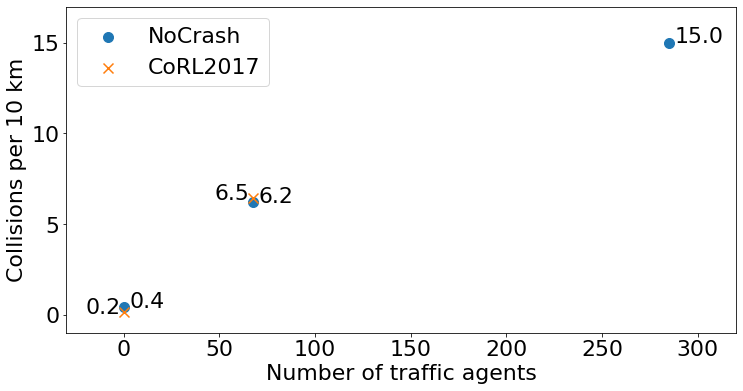

In [217]:
NOCRASH = np.array([0.4, 6.2, 15.0]).copy() # [0.4441099764726134, 7.712165700987876, 17.459489792224645]
CORL = np.array([0.15955320538093518, 6.463299546267825]) # [[0.15955320538093518, 6.463299546267825]

_, ax = plt.subplots(figsize=(12, 6))
ax.scatter([0, 67.5, 285], NOCRASH, label='NoCrash', s=100)
ax.scatter([0, 67.5], CORL, label='CoRL2017', marker='x', s=100)

for i, x in enumerate([0, 67.5, 285]):
    ax.annotate(round(NOCRASH[i], 1), (x+3, NOCRASH[i]))
    
for i, x in enumerate([0, 67.5]):
    ax.annotate(round(CORL[i], 1), (x-20, CORL[i]-0.1))

plt.ylim([-1, 17])
plt.xlim([-30, 320])
plt.legend()
plt.xlabel("Number of traffic agents")
plt.ylabel("Collisions per 10 km")
plt.show()

Infraction analysis collisions


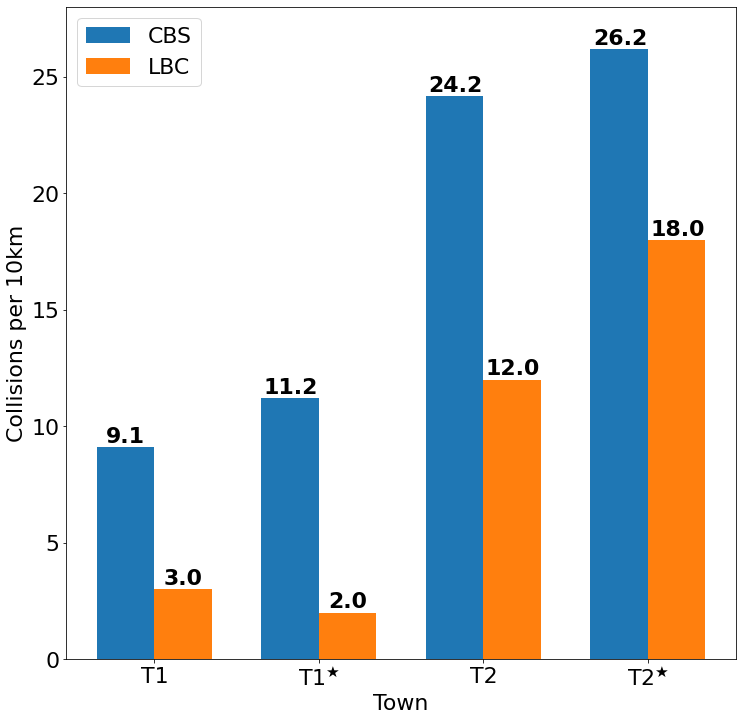

Infraction analysis traffic light violations


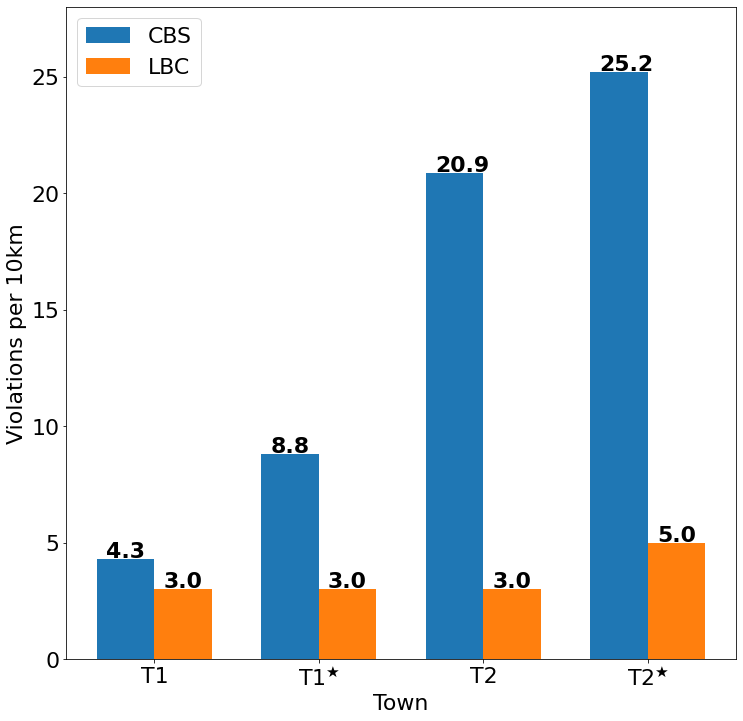

In [244]:
# plot_collisions_traffic([0.4, 6.2, 15.0], [0.15955320538093518, 6.463299546267825, np.NaN])
# plot_collisions_traffic(all_c)
plot_collisions(all_c)
plot_tls(all_t)

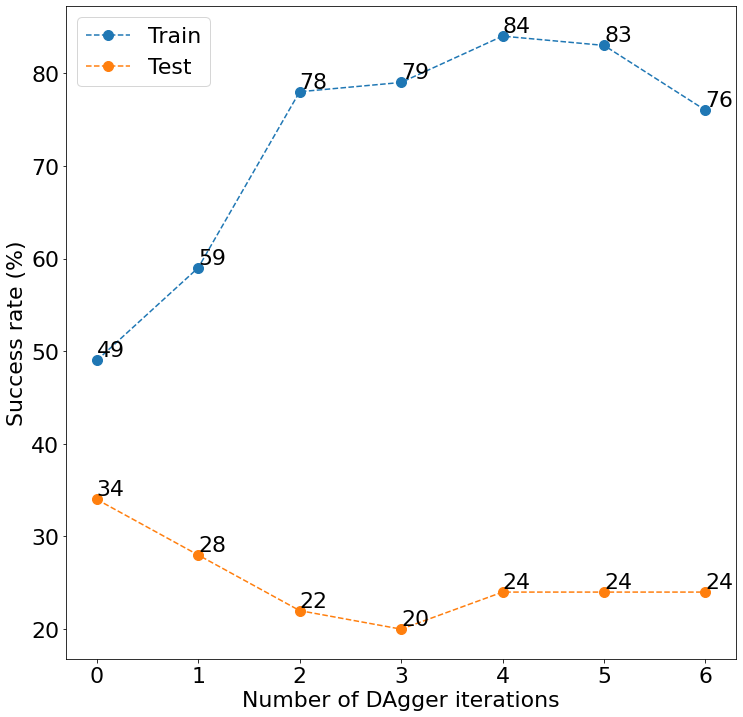

In [65]:
def DAgger(results, results2):
    _, ax = plt.subplots(figsize=(12, 12))
    ax.plot(results, linestyle='--', marker='o', markersize=10, label='Train')[0]
    ax.plot(results2, linestyle='--', marker='o', markersize=10, label='Test')[0]

    
    for i, x in enumerate(np.arange(0, len(results), 1.0)):
        ax.annotate(results[i], (x, results[i]+0.4))
        ax.annotate(results2[i], (x, results2[i]+0.4))
    
    plt.xticks(np.arange(0, len(results), 1.0))
    ax.set_xlabel("Number of DAgger iterations")
    ax.set_ylabel("Success rate (%)")
    
    plt.legend()
    plt.show()
    
plt.rcParams.update({'font.size': 22})
DAgger([49, 59, 78, 79, 84, 83, 76], [34, 28, 22, 20, 24, 24, 24])

In [12]:
def compare_success(s1, s2, label_group):
    def preprocess(data):        
        return [np.mean(data['success'][t:t+4]) for t in range(0, len(data), 4)]
        
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    s1.extend([0 for _ in range(len(s2)-len(s1))])
    
    s1 = np.array(s1)
    s2 = np.array(s2)
    
    labels = [i for i in range(len(s1))]
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(20,6))
    rects1 = ax.bar(x - width/2, s1, width, label=label_group[0])
    rects2 = ax.bar(x + width/2, s2, width, label=label_group[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Success rate percentage')
    ax.set_xlabel('Trajectory')
    ax.set_title(f'Success rate comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

In [14]:
# df2, _ = read_data("./")
# df3, _ = read_data("logs/30mei_noise_stage_0/benchmark/model-680_v2/FullTown01-v1_seed0")

# compare_success(df, df2, ['New controller - model 680', "Old controller - model 680"])